<a href="https://colab.research.google.com/github/xitonchong/dcgan_DRIVE/blob/master/drive_cisir2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://drive.grand-challenge.org/]
!git clone https://github.com/xitonchong/retina_data
 
'''DESIGN DOC:
--------------------------------
OBJECTIVE:  to demonstrate the capabilities of GAN of synthesizing medical images 
            through unconditional, semi-supervised manner.  (image synthesis)
DL LANGUAGE:  tensorflow 2.0, based on keras
            advantage over tensorflow version 1.x:  prebuild computation graph before execution
OTHER GAN TASK:  
            1.  image segmentation, where given retina image, identify location where lesion is present (if any)
            2.  computer vision task:  style transfer, super-resolution (DLSS), interpolate possible frame in between two successive video frame
GAN is a heuristic learning method where the cost function does not guarantee convergence, 
  As space get larger, GAN might have difficulties in guessing the fake image as generator is conjectured to have harder task of
  synthesizing image that is close to real image without looking at the input image, discriminator has "easier" task as it takes a look
  at both input and fake images.  All generator sees are scalar feedback from discriminator (*and its gradient)
  it is important to check gradient from output is properly backpropagated into front layers if GAN fails.  
  
'''

fatal: destination path 'retina_data' already exists and is not an empty directory.


'DESIGN DOC:\n--------------------------------\nOBJECTIVE:  to demonstrate the capabilities of GAN of synthesizing medical images \n            through unconditional, semi-supervised manner.  (image synthesis)\nDL LANGUAGE:  tensorflow 2.0, based on keras\n            advantage over tensorflow version 1.x:  prebuild computation graph before execution\nOTHER GAN TASK:  \n            1.  image segmentation, where given retina image, identify location where lesion is present (if any)\n            2.  computer vision task:  style transfer, super-resolution (DLSS), interpolate possible frame in between two successive video frame\nGAN is a heuristic learning method where the cost function does not guarantee convergence, \n  As space get larger, GAN might have difficulties in guessing the fake image as generator is conjectured to have harder task of\n  synthesizing image that is close to real image without looking at the input image, discriminator has "easier" task as it takes a look\n  at bo

In [0]:
mkdir -p images

In [0]:
'''from google.colab import files
files.upload()'''

'from google.colab import files\nfiles.upload()'

In [0]:
'''from google.colab import files
files.upload()'''

'from google.colab import files\nfiles.upload()'

In [0]:
ls

dcgan.png         processed_0.png  processed_4.png  processed_8.png
gan_training.jpg  processed_1.png  processed_5.png  processed_9.png
images/           processed_2.png  processed_6.png  retina_data/
logs/             processed_3.png  processed_7.png  sample_data/


In [0]:
!pip install matplotlib
!pip install tensorflow==2.0.0beta
!pip install pillow

In [0]:
from PIL import Image
import os
import numpy as np
import glob
import tensorflow as tf
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Reshape, Input, Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, Adam
import argparse
import math
import matplotlib.pyplot as plt
from IPython.display import Image, display

print(tf.__version__)

2.0.0-beta0


In [0]:
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

AUTOTUNE = tf.data.experimental.AUTOTUNE

#data_dir = '/tf/data'
data_dir = './retina_data'
data = os.path.join(data_dir, "*/images/*.jpg")
data_list = glob.glob(data)
print(type(data_list[0]))

#print(len(data_list))
assert len(data_list) == 40
random.shuffle(data_list)

# function ------------------------------------------

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [64, 64])
  image /= 255.0  # normalize to [0,1] range

  return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def change_range(image):
    # convert from [0,1] to [-1,1]
    return 2*image-1

#==================================================

<class 'str'>


In [0]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    batch_size=10,
    write_graph=True,
    write_grads=True
)


W0811 10:33:37.653332 139891251926912 callbacks.py:1467] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0811 10:33:37.655481 139891251926912 callbacks.py:1470] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


In [0]:
#pass each data path to dataset object
path_ds = tf.data.Dataset.from_tensor_slices(data_list)
#print('shape: ', repr(path_ds.output_shapes))
#print('type: ', path_ds.output_types)
print(path_ds)

ds = path_ds.map(load_and_preprocess_image)
BATCH_SIZE=10
ds  = ds.repeat()
ds  = ds.batch(BATCH_SIZE)
# buffer size refers to preload how many data into memory as a balance of speed and memory
# important for shuffling different batches into network
ds  = ds.prefetch(buffer_size=AUTOTUNE) 
keras_ds = ds.map(change_range)


<TensorSliceDataset shapes: (), types: tf.string>


0 (10, 64, 64, 3)
1 (10, 64, 64, 3)
2 (10, 64, 64, 3)
3 (10, 64, 64, 3)
4 (10, 64, 64, 3)
5 (10, 64, 64, 3)
6 (10, 64, 64, 3)
7 (10, 64, 64, 3)
8 (10, 64, 64, 3)
9 (10, 64, 64, 3)


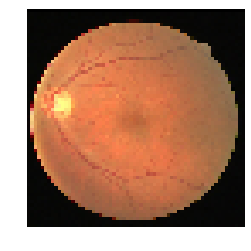

In [0]:
## testing the dataset object output
# having a sanity check on pixel min and max
for i in range(10):
    image = next(iter(keras_ds))
    print(i, image.shape)
    assert np.min(image) >= -1.0
    assert np.max(image) <= 1.0
    #print(np.min(image), np.max(image))
    # convert image to [0 .. 1] range as plt.savefig expects the value
    image = image*0.5 + 0.5
    plt.imshow(image[i,:,:,:])
    plt.axis('off')
    plt.savefig("./processed_%d.png" % i)

./processed_2.png


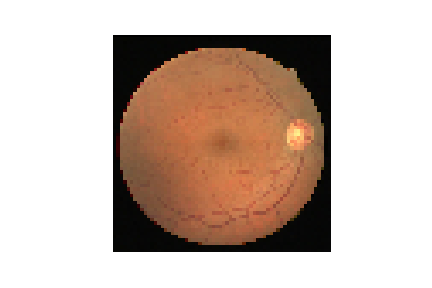

./processed_4.png


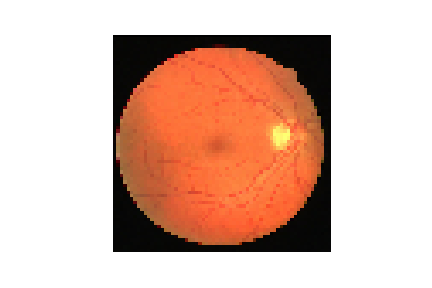

./processed_8.png


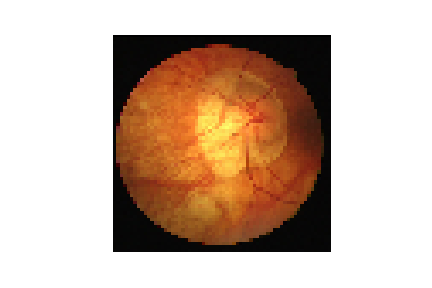

In [0]:
real = ['./processed_2.png', './processed_4.png', './processed_8.png']
# viewing down-resolutioned input images
for imageName in real:
    print(imageName)
    display(Image(filename=imageName))

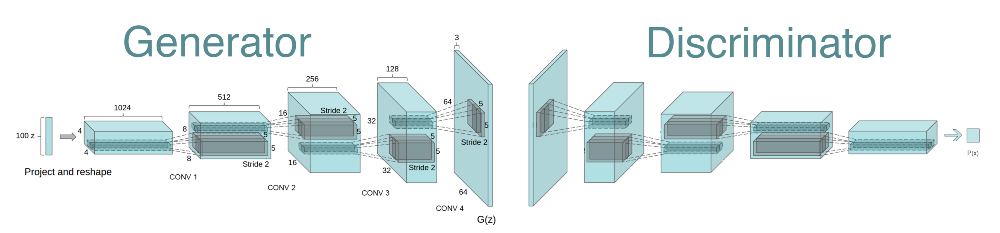

In [0]:
display(Image('./dcgan.png'))
# the dimension of this example is differnt than picture below. Serves as reference only.  

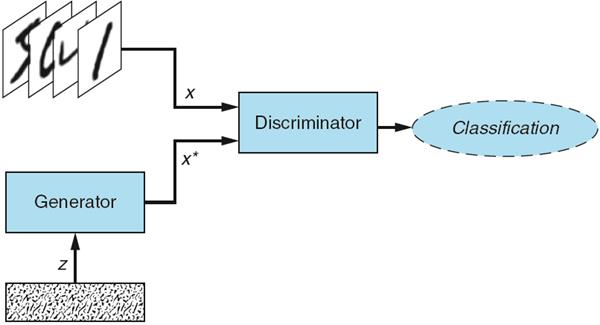

In [0]:
# GAN TRAINING FLOW
display(Image('./gan_training.jpg'))

In [0]:
# warpper to conventional function
def conv2d(filters, kernel_size, strides, padding):
    return Conv2D(filters=filters, kernel_size=kernel_size, 
                    strides=strides, padding=padding, 
                    kernel_initializer='he_normal')

def conv2dTranspose(filters, kernel_size, strides, padding):
    return Conv2D(filters=filters, kernel_size=kernel_size,
                    strides=strides, padding=padding, 
                    kernel_initializer='he_normal')


In [0]:
class DCGAN():
    def __init__(self):
        self.height = 64
        self.width  = 64
        self.channel= 3
        self.img_shape=(self.width, self.height, self.channel)
        self.latent_dim = 100
        layer_init = 'he_normal'  #kaiming he initializer

        optimizer = Adam(0.0002, 0.5)
        #optimizer = SGD(lr=0.00005)
        # build models
        self.dis = self._build_discriminator()
        # compile discriminator,  freeze discriminator pipe g to d, 
        self.dis.compile(loss='binary_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])

        # build generator
        self.gen = self._build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.gen(z)
        # set discriminator before compiling combined network ensures that
        # no gradient is flowing through discriminator
        self.dis.trainable = False
        valid = self.dis(img)

        # combined model
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', 
                    optimizer=optimizer)
        
        # tensorboard attach model
        tensorboard.set_model(self.dis)
        #tensorboard.set_model(self.combined)

    def _build_discriminator(self, padding='same'):
        
        model = tf.keras.Sequential()
        model.add(Conv2D(64, (3,3), strides=(2,2),
                input_shape=(self.height, self.width, self.channel),
                kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, (3,3), strides=(2,2), padding=padding,
            kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Conv2D(16, (3,3), strides=(2,2), padding=padding,
            kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        model.summary()
        x = Input(shape=self.img_shape)
        prob = model(x)
        return Model(x, prob)


    def _build_generator(self, padding='same'):

        model = tf.keras.Sequential()
        model.add(Dense(16*16*64, input_shape=(self.latent_dim,)))
        #model.add(Activation('relu'))
        model.add(Activation('relu'))
        model.add(Reshape((16, 16, 64),  input_shape=(16*16*64,)))
        model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(1,1),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(32, 
                kernel_size=(3,3), strides=(2,2),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(self.channel,
                kernel_size=(3,3), strides=(1,1),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('tanh'))
            
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img   = model(noise)

        return Model(noise, img)
               
    def train(self, epochs=1000, batch_size=32, save_interval=100):
        
        # adversarial ground trutg
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))
        
        for epoch in range(epochs+1):

            imgs = next(iter(keras_ds))
            #--------------------------
            # train discriminator
            #----------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.gen.predict(noise)

            d_loss_real = self.dis.train_on_batch(imgs, valid)
            d_loss_fake = self.dis.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #----------------------------
            #  train generator
            #-----------------------------
            g_loss = self.combined.train_on_batch(noise, valid)
            print("%4d [D loss: %4.3f, acc.: %.2f%%] [g loss: %4.3f]" %
                    (epoch, d_loss[0], d_loss[1]*100, g_loss))
            # tensorboard save
            tensorboard.on_epoch_end(epoch, named_logs(self.dis, d_loss))
            #tensorboard.on_epoch_end(epoch, named_logs(self.combined, g_loss))            
            if epoch % save_interval == 0:
                print("== saving images, ", epoch)
                self.save_imgs(epoch)


    def save_imgs(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_imgs=  self.gen.predict(noise)

        # rescale images 0-1
        gen_imgs = 0.5*gen_imgs + 0.5

        fig, axs = plt.subplots(r,c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/mnist_%d.png" % epoch)
        plt.close()

gan = DCGAN()
gan.train(batch_size=BATCH_SIZE)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0

W0811 10:33:41.014986 139891251926912 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0811 10:33:41.133306 139891251926912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 10:33:42.599890 139891251926912 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


   0 [D loss: 0.607, acc.: 65.00%] [g loss: 0.623]
== saving images,  0
   1 [D loss: 0.523, acc.: 55.00%] [g loss: 0.601]
   2 [D loss: 0.576, acc.: 65.00%] [g loss: 0.567]
   3 [D loss: 0.626, acc.: 50.00%] [g loss: 0.531]
   4 [D loss: 0.521, acc.: 60.00%] [g loss: 0.495]
   5 [D loss: 0.618, acc.: 50.00%] [g loss: 0.462]
   6 [D loss: 0.689, acc.: 45.00%] [g loss: 0.453]
   7 [D loss: 0.728, acc.: 45.00%] [g loss: 0.389]
   8 [D loss: 0.685, acc.: 60.00%] [g loss: 0.444]
   9 [D loss: 0.712, acc.: 55.00%] [g loss: 0.457]
  10 [D loss: 0.633, acc.: 50.00%] [g loss: 0.514]
  11 [D loss: 0.659, acc.: 50.00%] [g loss: 0.508]
  12 [D loss: 0.545, acc.: 70.00%] [g loss: 0.656]
  13 [D loss: 0.502, acc.: 60.00%] [g loss: 0.602]
  14 [D loss: 0.490, acc.: 70.00%] [g loss: 0.607]
  15 [D loss: 0.457, acc.: 60.00%] [g loss: 0.656]
  16 [D loss: 0.434, acc.: 80.00%] [g loss: 0.708]
  17 [D loss: 0.448, acc.: 80.00%] [g loss: 0.778]
  18 [D loss: 0.362, acc.: 85.00%] [g loss: 0.725]
  19 [D lo

W0811 10:37:06.236656 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:06.245507 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:06.248014 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:06.255886 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:06.261452 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 501 [D loss: 0.692, acc.: 50.00%] [g loss: 0.890]
 502 [D loss: 0.617, acc.: 55.00%] [g loss: 1.065]
 503 [D loss: 0.631, acc.: 60.00%] [g loss: 1.041]
 504 [D loss: 0.810, acc.: 50.00%] [g loss: 0.748]
 505 [D loss: 0.799, acc.: 40.00%] [g loss: 1.004]
 506 [D loss: 0.676, acc.: 55.00%] [g loss: 0.739]
 507 [D loss: 0.759, acc.: 50.00%] [g loss: 0.778]
 508 [D loss: 0.623, acc.: 70.00%] [g loss: 1.091]
 509 [D loss: 0.791, acc.: 55.00%] [g loss: 1.015]
 510 [D loss: 0.896, acc.: 45.00%] [g loss: 0.782]
 511 [D loss: 0.788, acc.: 50.00%] [g loss: 1.040]
 512 [D loss: 0.799, acc.: 45.00%] [g loss: 0.975]
 513 [D loss: 0.756, acc.: 50.00%] [g loss: 0.779]
 514 [D loss: 0.777, acc.: 55.00%] [g loss: 0.669]
 515 [D loss: 0.740, acc.: 50.00%] [g loss: 0.772]
 516 [D loss: 0.663, acc.: 50.00%] [g loss: 0.784]
 517 [D loss: 0.858, acc.: 50.00%] [g loss: 0.969]
 518 [D loss: 0.661, acc.: 60.00%] [g loss: 0.880]
 519 [D loss: 0.888, acc.: 55.00%] [g loss: 0.718]
 520 [D loss: 0.618, acc.: 60.0

W0811 10:37:45.333204 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.335630 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.340557 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.350573 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.352902 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.362994 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:37:45.365220 139891

 601 [D loss: 0.660, acc.: 60.00%] [g loss: 0.762]
 602 [D loss: 0.693, acc.: 45.00%] [g loss: 0.859]
 603 [D loss: 0.753, acc.: 50.00%] [g loss: 0.739]
 604 [D loss: 0.768, acc.: 40.00%] [g loss: 0.941]
 605 [D loss: 0.685, acc.: 45.00%] [g loss: 0.835]
 606 [D loss: 0.652, acc.: 60.00%] [g loss: 0.727]
 607 [D loss: 0.786, acc.: 50.00%] [g loss: 0.861]
 608 [D loss: 0.713, acc.: 60.00%] [g loss: 0.909]
 609 [D loss: 0.763, acc.: 50.00%] [g loss: 0.584]
 610 [D loss: 0.736, acc.: 40.00%] [g loss: 0.993]
 611 [D loss: 0.732, acc.: 45.00%] [g loss: 0.840]
 612 [D loss: 0.700, acc.: 55.00%] [g loss: 0.710]
 613 [D loss: 0.717, acc.: 55.00%] [g loss: 0.833]
 614 [D loss: 0.802, acc.: 40.00%] [g loss: 0.871]
 615 [D loss: 0.754, acc.: 45.00%] [g loss: 0.742]
 616 [D loss: 0.820, acc.: 45.00%] [g loss: 1.033]
 617 [D loss: 0.777, acc.: 45.00%] [g loss: 0.786]
 618 [D loss: 0.744, acc.: 50.00%] [g loss: 0.776]
 619 [D loss: 0.687, acc.: 65.00%] [g loss: 0.866]
 620 [D loss: 0.874, acc.: 30.0

W0811 10:38:25.855012 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.858121 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.862683 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.865705 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.869989 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.873135 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:38:25.876547 139891

 701 [D loss: 0.772, acc.: 35.00%] [g loss: 0.901]
 702 [D loss: 0.641, acc.: 55.00%] [g loss: 0.722]
 703 [D loss: 0.646, acc.: 60.00%] [g loss: 0.888]
 704 [D loss: 0.701, acc.: 45.00%] [g loss: 0.967]
 705 [D loss: 0.748, acc.: 55.00%] [g loss: 1.039]
 706 [D loss: 0.667, acc.: 55.00%] [g loss: 0.805]
 707 [D loss: 0.613, acc.: 65.00%] [g loss: 0.792]
 708 [D loss: 0.724, acc.: 50.00%] [g loss: 1.103]
 709 [D loss: 0.691, acc.: 45.00%] [g loss: 0.870]
 710 [D loss: 0.646, acc.: 65.00%] [g loss: 0.854]
 711 [D loss: 0.685, acc.: 50.00%] [g loss: 0.881]
 712 [D loss: 0.749, acc.: 35.00%] [g loss: 0.763]
 713 [D loss: 0.685, acc.: 55.00%] [g loss: 0.677]
 714 [D loss: 0.697, acc.: 50.00%] [g loss: 0.650]
 715 [D loss: 0.685, acc.: 70.00%] [g loss: 0.694]
 716 [D loss: 0.754, acc.: 45.00%] [g loss: 0.655]
 717 [D loss: 0.859, acc.: 30.00%] [g loss: 0.726]
 718 [D loss: 0.652, acc.: 55.00%] [g loss: 0.632]
 719 [D loss: 0.730, acc.: 50.00%] [g loss: 0.677]
 720 [D loss: 0.775, acc.: 45.0

W0811 10:39:07.409370 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.411997 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.416601 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.420660 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.424918 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.428545 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:07.431116 139891

 801 [D loss: 0.674, acc.: 70.00%] [g loss: 0.831]
 802 [D loss: 0.673, acc.: 55.00%] [g loss: 0.760]
 803 [D loss: 0.577, acc.: 75.00%] [g loss: 0.800]
 804 [D loss: 0.667, acc.: 60.00%] [g loss: 0.738]
 805 [D loss: 0.722, acc.: 35.00%] [g loss: 0.773]
 806 [D loss: 0.753, acc.: 50.00%] [g loss: 0.804]
 807 [D loss: 0.719, acc.: 60.00%] [g loss: 0.734]
 808 [D loss: 0.676, acc.: 70.00%] [g loss: 0.850]
 809 [D loss: 0.693, acc.: 55.00%] [g loss: 0.761]
 810 [D loss: 0.668, acc.: 55.00%] [g loss: 0.721]
 811 [D loss: 0.699, acc.: 45.00%] [g loss: 0.790]
 812 [D loss: 0.768, acc.: 60.00%] [g loss: 0.921]
 813 [D loss: 0.672, acc.: 55.00%] [g loss: 0.743]
 814 [D loss: 0.610, acc.: 75.00%] [g loss: 0.815]
 815 [D loss: 0.712, acc.: 45.00%] [g loss: 0.864]
 816 [D loss: 0.635, acc.: 65.00%] [g loss: 0.840]
 817 [D loss: 0.543, acc.: 85.00%] [g loss: 0.873]
 818 [D loss: 0.675, acc.: 65.00%] [g loss: 0.884]
 819 [D loss: 0.692, acc.: 65.00%] [g loss: 0.899]
 820 [D loss: 0.601, acc.: 70.0

W0811 10:39:49.238765 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.241147 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.243800 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.246705 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.249641 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.251794 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:39:49.254684 139891

 901 [D loss: 0.778, acc.: 30.00%] [g loss: 0.923]
 902 [D loss: 0.691, acc.: 55.00%] [g loss: 0.886]
 903 [D loss: 0.640, acc.: 70.00%] [g loss: 0.872]
 904 [D loss: 0.697, acc.: 60.00%] [g loss: 0.796]
 905 [D loss: 0.630, acc.: 65.00%] [g loss: 0.898]
 906 [D loss: 0.619, acc.: 65.00%] [g loss: 0.826]
 907 [D loss: 0.688, acc.: 55.00%] [g loss: 0.907]
 908 [D loss: 0.681, acc.: 60.00%] [g loss: 0.925]
 909 [D loss: 0.645, acc.: 70.00%] [g loss: 0.882]
 910 [D loss: 0.600, acc.: 70.00%] [g loss: 0.863]
 911 [D loss: 0.571, acc.: 75.00%] [g loss: 0.952]
 912 [D loss: 0.697, acc.: 40.00%] [g loss: 0.808]
 913 [D loss: 0.682, acc.: 65.00%] [g loss: 0.711]
 914 [D loss: 0.674, acc.: 60.00%] [g loss: 0.788]
 915 [D loss: 0.704, acc.: 60.00%] [g loss: 0.637]
 916 [D loss: 0.769, acc.: 45.00%] [g loss: 0.556]
 917 [D loss: 0.733, acc.: 50.00%] [g loss: 0.675]
 918 [D loss: 0.651, acc.: 55.00%] [g loss: 0.800]
 919 [D loss: 0.773, acc.: 40.00%] [g loss: 0.984]
 920 [D loss: 0.886, acc.: 50.0

W0811 10:40:31.844180 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.846759 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.850842 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.853917 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.856419 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.859336 139891251926912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0811 10:40:31.862199 139891

./images/mnist_0.png


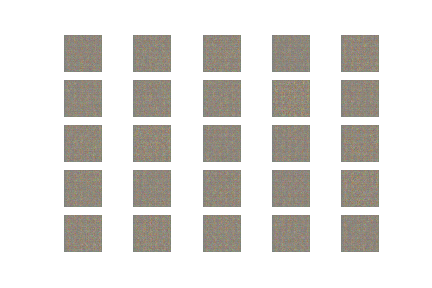

./images/mnist_600.png


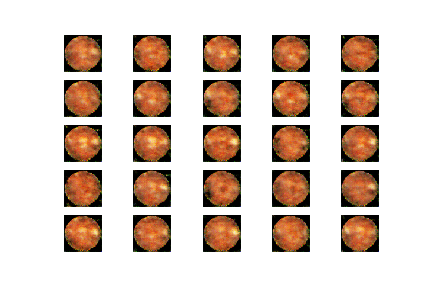

./images/mnist_1000.png


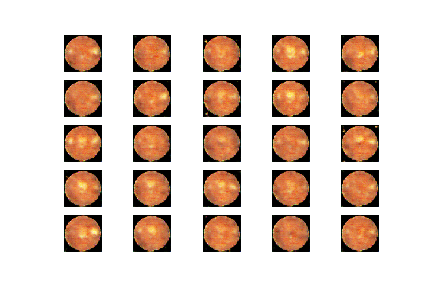

In [0]:
fake = ['./images/mnist_0.png', './images/mnist_600.png', './images/mnist_1000.png']

# viewing fake images produces by GAN
for imageName in fake:
    print(imageName)
    display(Image(filename=imageName))

./processed_2.png


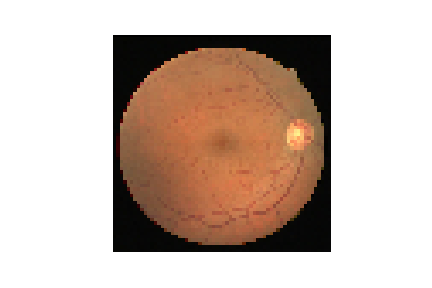

./processed_4.png


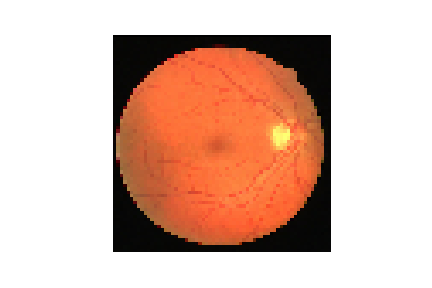

./processed_8.png


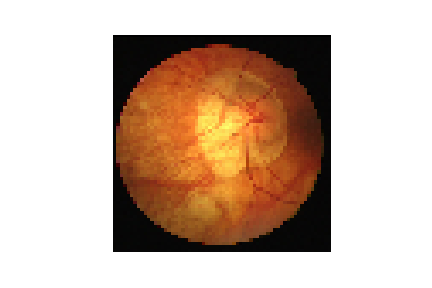

In [0]:
# viewing down-resolutioned input images
for imageName in real:
    print(imageName)
    display(Image(filename=imageName))

In [0]:
# TAKEAWAY:
'''
1.  processing input into tfRecords or tf dataset format
2.  GAN workflow and validate output
3.  Tensorboard directory is located in logs. Run tensorboard --logdir=./logs to see. 

HOMEWORK:
1.  checkpoint when training and reloading
2.  explore other type, task of GAN

'''

'\n1.  processing input into tfRecords or tf dataset format\n2.  GAN workflow\n3.  \n\n'